# Chapter 5 Case Study

We start off by a detailed look into the word2vec algorithm and examine a python implementation of the skip-gram model with negative sampling. Once the concepts underpinning word2vec are examined, we will use the Gensim package to speed up training time and investigate the translational properties of word embeddings. We will examine Glove embeddings as an alternative to word2vec. Both methods,  however, are unable to handle antonymy, polysemy and word-sense disambiguation. We will study how an embedding methods like sense2vec can better handle these issues. Lastly, we will examing document clustering by using an embeddings approach.

## Software Tools and Libraries

In this case study, we will be examining the inner operations of word2vec's skip-gram & negative sampling approach as well as GloVe embeddings with python. We will also leverage the popular nltk, gensim, glove_python, and spaCy libraries for our analysis. NLTK is a popular open-source toolkit for natural langauge processing and text analytics. The gensim library is an open-source toolkit for vector space modeling and topic modeling implemented in Python with Cython performance acceleration. The glove_python library is an efficient open-source implementation of GloVe in python. SpaCy is a fast open-source NLP library written in Python and Cython for part-of-speech tagging and named entity recognition.

For our analysis, we will leverage the Open American National Corpus, which consists of roughly 15 million spoken and written words from a variety of sources. Specifically, we will be using the subcorpus which consists of 4531 Slate magazine articles from 1996 to 2000 (approximately 4.2 million words). 


In [0]:
# Prepping our environment

# Basics
import glob
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.feature_extraction import stop_words
import math
import re
import string

# NLTK
import nltk
from nltk import tokenize, sent_tokenize

#from multiprocessing import Pool, Value, Array

# Tensorflow
# import tensorflow as tf
# from tensorflow import sigmoid
# # Keras
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential
# from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
# from keras.layers.embeddings import Embedding

print("Packages imported")

Packages imported


# 1. Exploratory Data Analysis



## 1.1. Google Drive

Let's connect to Google Drive and download the data as a tgz file and unarchive it.

In [0]:
# Link Google Drive

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
print("Connected to Google Drive")

Connected to Google Drive


In [0]:
# Get slate data:  http://www.anc.org/data/oanc/contents/#slate

file_list = drive.ListFile(
    {'q': "'1iIMsMnUR4f1DY_3VVJcEgnWyyN5FDn5e' in parents"}).GetList()
f = drive.CreateFile({'id':'1J9fs72nK1D7tiwjkfbS4cgmYPicTuZm4'})
f.GetContentFile('slate.tgz')

!tar xf slate.tgz
!ls slate

1   12	15  18	20  23	26  29	31  34	37  4	42  45	48  50	53  6  9
10  13	16  19	21  24	27  3	32  35	38  40	43  46	49  51	54  7
11  14	17  2	22  25	28  30	33  36	39  41	44  47	5   52	55  8


## 1.2. Load Data

Next, we load the slate news articles into a pandas dataframe.

In [0]:
#Load raw text files

ndf = pd.DataFrame(columns=["filename",'text'])

for datafile in glob.glob( "slate/*/*.txt" ):
    f=open(datafile,"r")
    ndf = ndf.append( {'filename':datafile,'text':f.read()} ,ignore_index=True)
    f.close()

ndf.count()

filename    4531
text        4531
dtype: int64

To process the data with word2vec, we must first split each article into separate sentences and create a new dataframe to hold them.

In [0]:
# Convert into dataframe of sentences

nltk.download('punkt')

df = pd.DataFrame()
for f in ndf['text']:
  sentence = sent_tokenize(f)
  df = df.append(sentence)
df.columns = ['text']
df.count()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


text    214225
dtype: int64

## 1.3. Preprocessing

Word2vec needs clean word tokens for **training**, so lets clean up the sentences by preprocessing to remove punctuation, hidden characters, and uppercase characters.

In [0]:
def process_text(text):
    
    text = re.sub(r"\\n", " ", text)
    text = re.sub(r"\n", " ", text)

    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
#    stops = stop_words.ENGLISH_STOP_WORDS
#    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    # Stemming
#     text = text.split()
#     stemmer = SnowballStemmer('english')
#     stemmed_words = [stemmer.stem(word) for word in text]
#     text = " ".join(stemmed_words)
    return text

# apply the above function to df['text']
df['text'] = df['text'].map(lambda x: process_text(x))

corpus = df['text'].tolist()
df.head()

,text
0,chatterdump : how to stop drudge etc
1,they may have finally found a way to neutraliz...
2,since the monica mess broke drudge has apparen...
3,the last one was jan 21 did you notice on meet...
4,peyronie disease of the chin


Let's calculate some basic statistics on this dataset, starting with document length and sentence length.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f156557dc88>]],
      dtype=object)

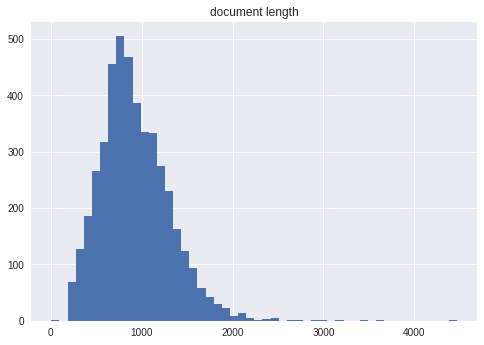

In [0]:
# document length histogram

pd.DataFrame([len(x.split()) for x in ndf['text']],columns= ['document length']).hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1565ec9a90>]],
      dtype=object)

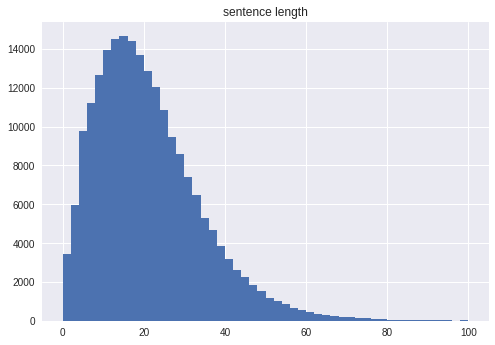

In [0]:
pd.DataFrame([len(x.split()) for x in df['text']],columns= ['sentence length']).hist(bins=50,range=(0,100))

Let's examine word-frequency by looking at the top 1000 terms in this corpus. The top 100 terms are what we typically consider stop-words, since they are common across most sentences and do not capture much, if any, semantic meaning. As we move further down, we start to see words that play a more important role in conveying the meaning within a sentence or document.

In [0]:
words = [tokenize.word_tokenize(x) for x in corpus]
words = [y for x in words for y in x]
word_freq = pd.DataFrame(nltk.FreqDist(words).most_common(1000), columns=['word','frequency'])
print(word_freq)

         word  frequency
0         the     266007
1          of     115973
2           -     114156
3          to     107951
4           a     100993
5         and      96375
6          in      74561
7        that      64448
8          is      51590
9          it      38175
10        for      38016
11        not      35118
12         on      30197
13         as      28392
14       with      26804
15         he      23882
16          i      23831
17        are      23022
18        but      22382
19         by      22304
20        was      22019
21        his      21901
22          :      21822
23       have      19955
24         be      19609
25       this      18631
26         an      18128
27        you      17305
28         at      16468
29       from      15870
..        ...        ...
970     costs        508
971    prices        508
972      male        508
973     named        507
974       fun        507
975   israeli        506
976   details        506
977     happy        506


In [0]:
word_freq.plot(xlim=(0,400))

#2.  Learning Word Embeddings

Our goal is to train a set of word embeddings for the corpus above. Let's build a skip-gram model with negative sampling, followed by a GloVe model. Before we train either model, let's see how many unique words exist in the preprocessed 4.86 million word corpus.



## 2.1. Create Dictionary of Vocabulary



In [0]:
# Tokenize and create dictionary

class VocabWord:
    def __init__(self, word):
        self.word = word
        self.count = 0


vocab_items = []
vocab_hash = {}
word_count = 0
        
for token in ['<bol>', '<eol>']:
        vocab_hash[token] = len(vocab_items)
        vocab_items.append(VocabWord(token))

for line in df['text']:
    tokens = line.split()
    for token in tokens:
        if token not in vocab_hash:
            vocab_hash[token] = len(vocab_items)
            vocab_items.append(VocabWord(token))

        #assert vocab_items[vocab_hash[token]].word == token, 'Wrong vocab_hash index'
        vocab_items[vocab_hash[token]].count += 1
        word_count += 1

        if word_count % 1000000 == 0:
            print("\rReading word %d" % word_count)

    # Add special tokens <bol> (beginning of line) and <eol> (end of line)
    vocab_items[vocab_hash['<bol>']].count += 1
    vocab_items[vocab_hash['<eol>']].count += 1
    word_count += 2

print('Total words in training file: %d' % word_count)
print('Vocab size: %d' % len(vocab_items))

Reading word 1000000
Reading word 2000000
Reading word 4000000
Total words in training file: 4860294
Vocab size: 77440


## 2.2. Word2Vec

We are now ready to train the neural network of the word2vec model. Let's define our model parameters:

*  dim = dimension of the word vectors
*  win = context window size (number of tokens)
*  start_alpha = starting learning rate
*  neg = number of samples for negative sampling
*  min_count = minimum number of mentions for a word to be included in vocabulary






In [0]:
# Initialize parameters of neural network

dim = 100
win = 10
start_alpha = 0.05
neg = 10
min_count = 5

## 2.3. Handling Rare Words

We want to filter out rare words that have few mentions than our min_count threshold. We will be mapping all of these words to a special out-of-vocabulary token. 

In [0]:
# truncate dictionary and map rare words to <unk> token
truncated = []
truncated.append(VocabWord('<unk>'))
unk_hash = 0

count_unk = 0
for token in vocab_items:
    if token.count < min_count:
        count_unk += 1
        truncated[unk_hash].count += token.count
    else:
        truncated.append(token)

truncated.sort(key=lambda token : token.count, reverse=True)

vocab_hash = {}
for i, token in enumerate(truncated):
    vocab_hash[token.word] = i

vocab_items = truncated
vocab_hash = vocab_hash
vocab_size = len(vocab_items)
print('Unknown vocab size:', count_unk)
print('Truncated vocab size: %d' % vocab_size)

Unknown vocab size: 45842
Truncated vocab size: 31599


## 2.4. Negative Sampling

To speed up training, let's create a negative sampling lookup table that we will use during training.

In [0]:
# Create table of probabilities for negative sampling

power = 0.75
norm = sum([math.pow(t.count, power) for t in vocab_items]) # Normalizing constant

table_size = int(1e8) # Length of the unigram table
table = np.zeros(table_size, dtype=np.int)

p = 0 # Cumulative probability
i = 0
for j, unigram in enumerate(vocab_items):
    p += float(math.pow(unigram.count, power))/norm
    while i < table_size and float(i) / table_size < p:
        table[i] = j
        i += 1
        
def sample(table,count):
    indices = np.random.randint(low=0, high=len(table), size=count)
    return [table[i] for i in indices]

## 2.5. Training the Model

We are now ready to train the word2vec model. The approach is to train a two-layer (syn0, syn1) neural network by iterating over the sentences in the corpus and adjusting lawyer weights to maximize the probabilities of context words given a target word (skip-gram) with negative sampling. After completion, the weights of the hidden layer syn0 are the word embeddings that we seek.

In [0]:
# Train skip-gram with negative sampling
import struct

# Sigmoid Function
def sigmoid(z):
    if z > 6:
        return 1.0
    elif z < -6:
        return 0.0
    else:
        return 1 / (1 + math.exp(-z))
    
# Init syn0 with uniform distribution on the interval [-0.5, 0.5]/dim
tmp = np.random.uniform(low=-0.5/dim, high=0.5/dim, size=(vocab_size, dim))
syn0 = np.ctypeslib.as_ctypes(tmp)
syn0 = np.array(syn0)


tmp = np.zeros(shape=(vocab_size, dim))
syn1 = np.ctypeslib.as_ctypes(tmp)
syn1 = np.array(syn1)
    
current_sent = 0
truncated_vocabulary = [x.word for x in vocab_items]
corpus = df['text'].tolist()

while current_sent < df.count()[0]:
    line = corpus[current_sent]
    sent = [vocab_hash[token] if token in truncated_vocabulary else vocab_hash['<unk>'] 
            for token in [['<bol>'] + line.split() + ['<eol>']]]
    for sent_pos, token in enumerate(sent):
        
        current_win = np.random.randint(low=1, high=win+1)
        context_start = max(sent_pos - current_win, 0)
        context_end = min(sent_pos + current_win + 1, len(sent))
        context = sent[context_start:sent_pos] + sent[sent_pos+1:context_end]

        for context_word in context:
            embed = np.zeros(DIM)
            classifiers = [(token, 1)] + [(target, 0) for target in table.sample(neg)]
            for target, label in classifiers:
                z = np.dot(syn0[context_word], syn1[target])
                p = sigmoid(z)
                g = alpha * (label - p)
                embed += g * syn1[target] 
                syn1[target] += g * syn0[context_word] 
            syn0[context_word] += embed

        word_count += 1
    current_sent += 1
    if current_sent % 2000 == 0:
        print("\rReading sentence %d" % current_sent)


embedding = dict(zip(truncated_vocabulary,syn0))
print("Trained embeddings")

# Save embedding

fo = open("word2vec", 'w+')
for token, vector in zip(truncated_vocabulary, syn0):
    fo.write('%s ' % token)
    for s in vector:
        fo.write(('%f '% s))
    fo.write('\n')
fo.close()

print(syn0.shape)
    

Reading sentence 2000
Reading sentence 4000
Reading sentence 6000
Reading sentence 8000
Reading sentence 10000
Reading sentence 12000
Reading sentence 14000
Reading sentence 16000
Reading sentence 18000
Reading sentence 20000
Reading sentence 22000
Reading sentence 24000
Reading sentence 26000
Reading sentence 28000
Reading sentence 30000
Reading sentence 32000
Reading sentence 34000
Reading sentence 36000
Reading sentence 38000
Reading sentence 40000
Reading sentence 42000
Reading sentence 44000
Reading sentence 46000
Reading sentence 48000
Reading sentence 50000
Reading sentence 52000
Reading sentence 54000
Reading sentence 56000
Reading sentence 58000
Reading sentence 60000
Reading sentence 62000
Reading sentence 64000
Reading sentence 66000
Reading sentence 68000
Reading sentence 70000
Reading sentence 72000
Reading sentence 74000
Reading sentence 76000
Reading sentence 78000
Reading sentence 80000
Reading sentence 82000
Reading sentence 84000
Reading sentence 86000
Reading sentenc

The semantic translation properties of these embeddings are noteworthy. Let's examine the cosine similarity between two similar words (man, woman) and two dissimilar words (candy, social). We would expect the similar words to exhibit higher similarity.



In [0]:
from sklearn.metrics.pairwise import cosine_similarity

print(cosine_similarity([embedding['man']],[embedding['woman']]))
print(cosine_similarity([embedding['candy']],[embedding['social']]))

[[0.01258108]]
[[0.05319491]]


## 2.6. Visualize Embedding space

We can visualize the word embeddings using the T-SNE algorithm to map the embeddings to 2D space. Note that T-SNE is a dimensionality reduction technique that preserves notions of proximity within a vector space (points close together in 2D are close in proximity in higher dimensions). The figure below shows the relationships of a 300 word sample from the vocabulary.  

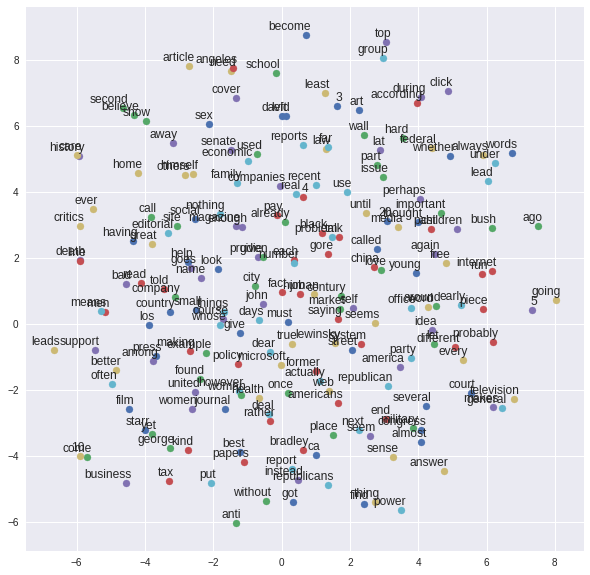

In [0]:
from sklearn.manifold import TSNE
from matplotlib import pylab

words = truncated_vocabulary[200:400]
embeddings = syn0
words_embedded = TSNE(n_components=2).fit_transform(embeddings[200:400])

pylab.figure(figsize=(10, 10))
for i, label in enumerate(words):
  x, y = words_embedded[i, :]
  pylab.scatter(x, y)
  pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                 ha='right', va='bottom')
pylab.show()

## 2.7. Using the Gensim package

The python code above is useful for understanding principles, but is not the fastest to run. The original word2vec package was written in C++ to faciliate rapid training speed over multiple cores. The gensim package provides an API to the word2vec library, as well as several useful methods to examine vectors neighborhoods. Let's see how we can use gensim to train on the sample data corpus.

In [0]:
!pip install -q gensim==3.2.0

import gensim


Gensim expects us to provide a set of documents as a list of list of tokens. We will call the simple_preprocess() method of gensim to remove punctuation, special and uppercase characters.

In [0]:
documents = [gensim.utils.simple_preprocess(df['text'].iloc[i]) for i in range(len(df))]

With the wrapper api provided by the gensim package, training word2vec is as simple as defining a model and passing the set of training documents.

In [0]:
model = gensim.models.Word2Vec(documents,
                                size=100,
                                window=10,
                                min_count=2,
                                workers=10)
model.train(documents, total_examples=len(documents), epochs=10)

32581186

## 2.8. Similarity

Let's assess the quality of the learned word embeddings by examining word neighborhoods. If we look at the most similar words to "man" or "book", we find highly similar words in their neighborhoods. So far so good.

In [0]:
model.wv.most_similar("man",topn=5)

[('guy', 0.6880463361740112),
 ('woman', 0.6301935315132141),
 ('person', 0.6296881437301636),
 ('soldier', 0.5808842182159424),
 ('someone', 0.5552011728286743)]

In [0]:
model.wv.most_similar("book",topn=5)

[('books', 0.7232613563537598),
 ('novel', 0.6448987126350403),
 ('biography', 0.6039375066757202),
 ('memoir', 0.6010321378707886),
 ('chapter', 0.5646576881408691)]

Let's look at some polysemic words. The similar words to the word "bass" reflect the music definition of bass. That is, they only capture a single word sense (there are no words related to the aquatic definition of bass). Similarly, words similar to "bank" all reflect its financial word sense, but no seashores or riverbeds. This is one of the major shortcomings of word2vec. 

In [0]:
model.wv.most_similar("bass",topn=5)

[('guitar', 0.6996911764144897),
 ('solo', 0.6786242723464966),
 ('blazer', 0.6665750741958618),
 ('roars', 0.6658747792243958),
 ('corduroy', 0.6525936126708984)]

In [0]:
model.wv.most_similar("bank",topn=5)

[('banks', 0.6580432653427124),
 ('bankers', 0.5862468481063843),
 ('imf', 0.5782995223999023),
 ('reserves', 0.5546875),
 ('loans', 0.5457302331924438)]

We can examine the semantic translation properties in more detail with some vector algebra. If we start with the word 'son' and subtract 'man' and add 'woman', we indeed find that 'daughter' is the closest word to the resulting sum. Similarly, if we invert the operation and start with the word 'daughter' and subtract 'woman' and add 'man', we find that 'son' is closest to the sum. Note that reciprocity is not guaranteed with word2vec.

In [0]:
model.wv.similar_by_vector(model.wv['son']-model.wv['man']+model.wv['woman'],topn=5)

[('daughter', 0.7489624619483948),
 ('sister', 0.7321654558181763),
 ('mother', 0.7243343591690063),
 ('boyfriend', 0.7229076623916626),
 ('lover', 0.7120637893676758)]

In [0]:
model.wv.similar_by_vector(model.wv['daughter']-model.wv['woman']+model.wv['man'],topn=5)

[('son', 0.7144862413406372),
 ('daughter', 0.6668421030044556),
 ('man', 0.6652499437332153),
 ('grandfather', 0.5896619558334351),
 ('father', 0.585667073726654)]

We can also see that word2vec captures geographic similarities by taking the word 'paris', subtracting 'france' and adding 'russia'. There resulting sum is close to what we expect - 'moscow'.

In [0]:
model.wv.similar_by_vector(model.wv['paris']-model.wv['france']+model.wv['russia'],topn=5)

[('russia', 0.7788714170455933),
 ('moscow', 0.6269053220748901),
 ('brazil', 0.6154285669326782),
 ('japan', 0.592476487159729),
 ('gazeta', 0.5799405574798584)]

We have previously discussed that word embeddings generated by word2vec are unable to distinguish antonyms, as these words often share the same context words in normal usage and consequentially have learned embeddings close to each other. For instance, the most similar word to 'large' is 'small', or the most similar word to 'hard' is 'easy'. Antonymy is hard! 

In [0]:
model.wv.most_similar("large",topn=5)

[('small', 0.726446270942688),
 ('enormous', 0.5439934134483337),
 ('huge', 0.5070887207984924),
 ('vast', 0.5017688870429993),
 ('size', 0.48968151211738586)]

In [0]:
model.wv.most_similar("hard",topn=5)

[('easy', 0.6564798355102539),
 ('difficult', 0.6085934638977051),
 ('tempting', 0.5201482772827148),
 ('impossible', 0.5099537372589111),
 ('easier', 0.4868208169937134)]

## 2.9. GloVe

Whereas word2vec captures the local context of words within sentences, GloVe embeddings can additionally account for global context across the corpus. Let's take a deeper dive on how to calculate GloVe embeddings. We begin by building a vocabulary dictionary from the corpus.

In [0]:
# Build vocab

from collections import Counter

vocab_count = Counter()

for line in corpus:
    tokens = line.strip().split()
    vocab_count.update(tokens)

vocab = {word: (i, freq) for i, (word, freq) in enumerate(vocab_count.items())}

## 2.10. Co-occurence matrix

Let's build the word co-occurence matrix from the corpus.  Note that word occurrences go both ways, from the main word to context, and vice versa. For smaller values of the context window, this matrix is expected to be sparse.

In [0]:
# Build co-occurrence matrix

from scipy import sparse

min_count = 10
window_size = 5

vocab_size = len(vocab)
id2word = dict((i, word) for word, (i, _) in vocab.items())
occurrence = sparse.lil_matrix((vocab_size, vocab_size),dtype=np.float64)

for i, line in enumerate(corpus):
    tokens = line.split()
    token_ids = [vocab[word][0] for word in tokens]

    for center_i, center_id in enumerate(token_ids):
        # Collect all word IDs in left window of center word
        context_ids = token_ids[max(0, center_i - window_size) : center_i]
        contexts_len = len(context_ids)

        for left_i, left_id in enumerate(context_ids):
            # Distance from center word
            distance = contexts_len - left_i

            # Weight by inverse of distance between words
            increment = 1.0 / float(distance)

            # Build co-occurrence matrix symmetrically (pretend we
            # are calculating right contexts as well)
            occurrence[center_id, left_id] += increment
            occurrence[left_id, center_id] += increment
    if i % 10000 == 0:
        print("Processing sentence %d" % i)

# Create a generator for efficient calculation

def occur_matrix(vocab, coccurrence, min_count):
  for i, (row, data) in enumerate(zip(coccurrence.rows, coccurrence.data)):
    if min_count is not None and vocab[id2word[i]][1] < min_count:
        continue

    for data_idx, j in enumerate(row):
        if min_count is not None and vocab[id2word[j]][1] < min_count:
            continue

        yield i, j, data[data_idx]

print("Creating co-occurrence matrix generator")
comatrix = occur_matrix(vocab, occurrence, min_count)


Processing sentence 0
Processing sentence 10000
Processing sentence 20000
Processing sentence 30000
Processing sentence 40000
Processing sentence 50000
Processing sentence 60000
Processing sentence 70000
Processing sentence 80000
Processing sentence 90000
Processing sentence 100000
Processing sentence 110000
Processing sentence 120000
Processing sentence 130000
Processing sentence 140000
Processing sentence 150000
Processing sentence 160000
Processing sentence 170000
Processing sentence 180000
Processing sentence 190000
Processing sentence 200000
Processing sentence 210000
Creating co-occurrence matrix generator


## 2.11. GloVe training

We can now train the embeddings by iterating over the documents (sentences) in the corpus.





In [0]:
# Train Glove Embeddings

from random import shuffle
from math import log
import pickle

iterations = 30
dim = 100
learning_rate = 0.05
x_max = 100
alpha = 0.75

vocab_size = len(vocab)
W = (np.random.rand(vocab_size * 2, dim) - 0.5) / float(dim + 1)
biases = (np.random.rand(vocab_size * 2) - 0.5) / float(dim + 1)

gradient_squared = np.ones((vocab_size * 2, dim), dtype=np.float64)
gradient_squared_biases = np.ones(vocab_size * 2, dtype=np.float64)

data = [(W[i_main], W[i_context + vocab_size],
             biases[i_main : i_main + 1],
             biases[i_context + vocab_size : i_context + vocab_size + 1],
             gradient_squared[i_main], gradient_squared[i_context + vocab_size],
             gradient_squared_biases[i_main : i_main + 1],
             gradient_squared_biases[i_context + vocab_size
                                     : i_context + vocab_size + 1],
             cooccurrence)
            for i_main, i_context, cooccurrence in comatrix]

for i in range(iterations):
    global_cost = 0
    shuffle(data)
    for (v_main, v_context, b_main, b_context, gradsq_W_main, gradsq_W_context,
         gradsq_b_main, gradsq_b_context, cooccurrence) in data:

        weight = (cooccurrence / x_max) ** alpha if cooccurrence < x_max else 1

        cost_inner = (v_main.dot(v_context)
                      + b_main[0] + b_context[0]
                      - log(cooccurrence))
        cost = weight * (cost_inner ** 2)
        global_cost += 0.5 * cost

        grad_main = weight * cost_inner * v_context
        grad_context = weight * cost_inner * v_main
        grad_bias_main = weight * cost_inner
        grad_bias_context = weight * cost_inner

        v_main -= (learning_rate * grad_main / np.sqrt(gradsq_W_main))
        v_context -= (learning_rate * grad_context / np.sqrt(gradsq_W_context))

        b_main -= (learning_rate * grad_bias_main / np.sqrt(gradsq_b_main))
        b_context -= (learning_rate * grad_bias_context / np.sqrt(
                gradsq_b_context))

        gradsq_W_main += np.square(grad_main)
        gradsq_W_context += np.square(grad_context)
        gradsq_b_main += grad_bias_main ** 2
        gradsq_b_context += grad_bias_context ** 2
    print('iteration = ',i,' cost = ',global_cost)
    
# Save model

with open("glove","wb") as f:
    pickle.dump(W, f, protocol=2)

The learned weight matrix consists of two sets of vectors, one if the word is in the main word position and one for the context word position. We will average them to generate the final GloVe embeddings for each word.

In [0]:
# Merge main and context word vectors by taking average

def merge_vectors(W, merge_fun=lambda m, c: np.mean([m, c], axis=0)):

    vocab_size = int(len(W) / 2)
    for i, row in enumerate(W[:vocab_size]):
        merged = merge_fun(row, W[i + vocab_size])
        merged /= np.linalg.norm(merged)
        W[i, :] = merged

    return W[:vocab_size]

embedding = merge_vectors(W)
len(embedding)

77438

##2.12. GloVe Vector Similarity

Let's examine the translational properties of these vectors. We define a simple function that returns the 5 most similar words to the word "man".

In [0]:
# Find most similar words

def most_similar(W, vocab, id2word, word, n=5):
    """
    Find the `n` words most similar to the given `word`. The provided
    `W` must have unit vector rows, and must have merged main- and
    context-word vectors (i.e., `len(W) == len(word2id)`).
    Returns a list of word strings.
    """

    assert len(W) == len(vocab)

    word_id = vocab[word][0]

    dists = np.dot(W, W[word_id])
    top_ids = np.argsort(dists)[::-1][:n + 1]

    return [(id2word[id],dists[id]) for id in top_ids if id != word_id][:n]

for term in most_similar(embedding, vocab, id2word, 'man', 5): print(term)

('woman', 0.9718018808969603)
('girl', 0.9262655177669397)
('single', 0.9222400016708986)
('dead', 0.9187203648559261)
('young', 0.9081009733127359)


Interestingly, the similarirty results fall into two categories. Whereas "woman" and "girl" have similar semantic meaning to 'man', the words "dead" and "young" do not. But these words do co-occur often, with phrases such as "young man" or "dead man". GloVe embeddings can capture both contexts. We can see this when we visualize the embeddings using T-SNE.

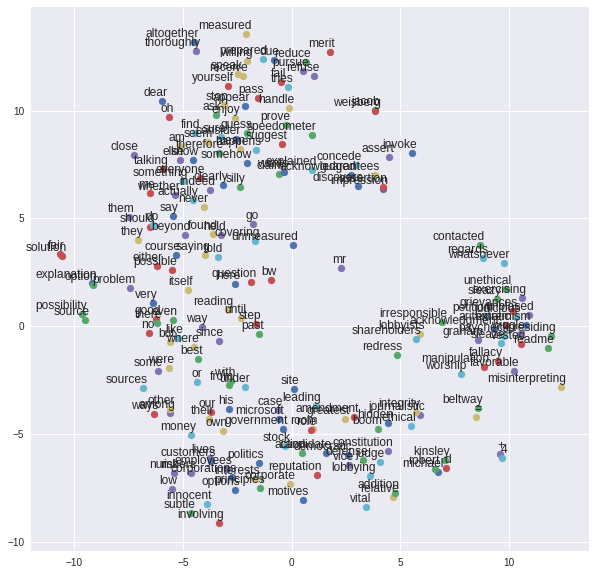

In [0]:
from sklearn.manifold import TSNE
from matplotlib import pylab

words = list(vocab.keys())[200:400]
words_embedded = TSNE(n_components=2).fit_transform(embedding[200:400])

pylab.figure(figsize=(10, 10))
for i, label in enumerate(words):
  x, y = words_embedded[i, :]
  pylab.scatter(x, y)
  pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                 ha='right', va='bottom')
pylab.show()

## 2.13. Using the Glove Package

While useful, our python implemention is too slow to run with a large corpus. The 'glove' and 'glove_python' libraries are python packages that implement the GloVe algoritm efficiently. Let's retrain our embeddings using the 'glove_python' package.

In [0]:
!pip install glove_python

from glove import Corpus, Glove

    100% |████████████████████████████████| 266kB 5.1MB/s 
  Running setup.py bdist_wheel for glove-python ... - \ | / - \ | / done
  Stored in directory: /root/.cache/pip/wheels/88/4b/6d/10c0d2ad32c9d9d68beec9694a6f0b6e83ab1662a90a089a4b
Successfully built glove-python


To do so, we begin by defining a corpus of documents. 

In [0]:
corpus = Corpus()

corpus.fit(documents, window=5)

We then learn embeddings from this corpus.

In [0]:
glove = Glove(no_components=100, learning_rate=0.05)

glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)

Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


Let's asses the quality of these embeddings by examining a few words.

In [0]:
glove.most_similar('man',number=6)

[('woman', 0.9417155142176431),
 ('young', 0.8541752252243202),
 ('guy', 0.8138920634188781),
 ('person', 0.8044470112897205),
 ('girl', 0.793038798219135)]

In [0]:
glove.most_similar('nice',number=6)

[('guy', 0.7583150809899194),
 ('very', 0.7071106359169386),
 ('seems', 0.7048211092737807),
 ('terrible', 0.697033427158236),
 ('fun', 0.6898111303194308)]

In [0]:
glove.most_similar('apple',number=6)

[('industry', 0.6965166116455955),
 ('employee', 0.6724064797672178),
 ('fbi', 0.6280345651329606),
 ('gambling', 0.6276268857034702),
 ('indian', 0.6266591982382662)]

Once again, the most similar words exhibit both semantic similarity as well as high co-occurrence probability. Even with the additional context, GloVe embeddings still lack the ability to handle antonyms and word sense disambiguation. 

# 3. Document Clustering

The use of word embeddings provides a useful and efficient means for document clustering in comparison to traditional approaches such as LSA or LDA. The simplest approach is a bag-of-words method where a document vector is created by averaging the vectors of each of the words in the document. Let's take our Slate corpus and see what we can find with this approach.



##3.1. Document vectors

We create a set of document vectors by adding the vectors of each word in the document and dividing by the total number of words.

In [0]:
documents = [gensim.utils.simple_preprocess(ndf['text'].iloc[i]) for i in range(len(ndf))]
corpus = Corpus()
corpus.fit(documents, window=5)
glove = Glove(no_components=100, learning_rate=0.05)
glove.fit(corpus.matrix, epochs=10, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)
print("Glove embeddings trained.")

doc_vectors = []
for doc in documents:
    vec = np.zeros(glove.word_vectors[glove.dictionary['the']].shape)
    for token in doc:
      vec += glove.word_vectors[glove.dictionary[token]]
    if len(doc) > 0:
      vec = vec/len(doc)
    doc_vectors.append(vec)
    
print("Processed documents = ",len(doc_vectors))

Performing 10 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Glove embeddings trained.
Processed documents =  4531


## 3.2. Cluster Analysis

Let's visualize these embeddings and see if we can spot any clusters.

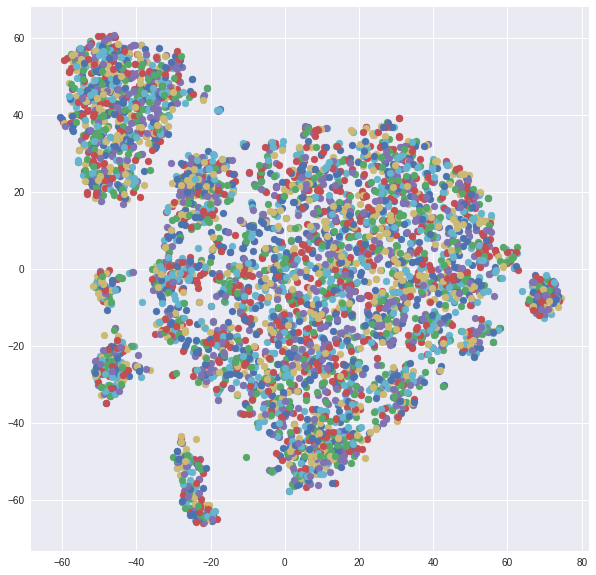

In [0]:
from sklearn.manifold import TSNE
from matplotlib import pylab

docs_embedded = TSNE(n_components=2).fit_transform(doc_vectors)

pylab.figure(figsize=(10, 10))
for i, label in enumerate(docs_embedded):
  x, y = docs_embedded[i, :]
  pylab.scatter(x, y)
pylab.show()

# 4. Word Sense Disambiguation

Word sense disambiguation is an important task in computational linguistics. However, word2vec or GloVe embeddings map words to a single embedding vector, and therefore lack the ability to disambiguate between multiple senses of words. The sense2vec algorithm is an improved approach that can deal with polysemy or antonymy through supervised disambiguation. Moreover, sense2vec is computationally inexpensive and can be implemented as a preprocessing task prior to training a word2vec or GloVe model. To see this, let's apply the sense2vec algoritm to our corpus by leveraging the spaCy library to generate part-of-speech labels that will serve as our supervised disambiguation labels.


## 4.1. Load spaCy

In [0]:
!pip install spacy
!python -m spacy download en

import spacy
nlp = spacy.load('en',disable=['parser', 'ner'])

print('Model loaded')


    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')

Model loaded


## 4.2. Supervised Disambiguation Annotations

Let's process the sentences in our corpus using the spaCy NLP annotations.

In [0]:
corpus = df['text'].tolist()
print("Number of docs = ",len(corpus))

docs = []
count = 0
for item in corpus:
  docs.append(nlp(item))
  count += 1
  if count % 10000 == 0:
    print("Processed document #",count)

## 4.3. POS Label Annotation

We will create a separate corpus where each word is augmented by its part-of-speech label. For instance, the word 'he' is mapped to 'he_PRON'.

In [0]:
sense_corpus = [[x.text+"_"+x.pos_ for x in y] for y in docs]
print(corpus[0])
print(' '.join(sense_corpus[0]))

balancing the budget in 1995 the budget battle between president clinton and the republican congress shut down the government 
balancing_VERB the_DET budget_NOUN in_ADP 1995_NUM the_DET budget_NOUN battle_NOUN between_ADP president_NOUN clinton_NOUN and_CCONJ the_DET republican_ADJ congress_NOUN shut_VERB down_PART the_DET government_NOUN


## 4.4. Train using word2vec

With the new preprocessed corpus, we can proceed with training word2vec.

In [0]:
model = gensim.models.Word2Vec(sense_corpus,
                                size=100,
                                window=10,
                                min_count=2,
                                workers=10)
model.train(sense_corpus, total_examples=len(sense_corpus), epochs=10)

34907945

## 4.5. Evaluate Word Sense Disambiguation

We can use this trained model to look at how words like 'run' or 'lie' can be disambiguated based on their part-of-speech.

In [0]:
model.wv.most_similar("run_NOUN",topn=5)

[('runs_NOUN', 0.5418172478675842),
 ('term_NOUN', 0.5085563063621521),
 ('ropy_VERB', 0.5027114152908325),
 ('distance_NOUN', 0.49787676334381104),
 ('sosa_NOUN', 0.4942496120929718)]

In [0]:
model.wv.most_similar("run_VERB",topn=5)

[('put_VERB', 0.6089274883270264),
 ('work_VERB', 0.599068284034729),
 ('hold_VERB', 0.5984195470809937),
 ('break_VERB', 0.5887631177902222),
 ('get_VERB', 0.5873323082923889)]

In [0]:
model.wv.most_similar("lie_NOUN",topn=5)

[('truth_NOUN', 0.6057517528533936),
 ('guilt_NOUN', 0.5678446888923645),
 ('sin_NOUN', 0.565475344657898),
 ('perjury_NOUN', 0.5402902364730835),
 ('madness_NOUN', 0.5183135867118835)]

In [0]:
model.wv.most_similar("lie_VERB",topn=5)

[('talk_VERB', 0.662897527217865),
 ('expose_VERB', 0.64887535572052),
 ('testify_VERB', 0.6263021230697632),
 ('commit_VERB', 0.6155776381492615),
 ('leave_VERB', 0.5946056842803955)]